In [11]:
from syserol.tensor import perform_CMTF
from syserol.dataImport import createCube, importFunction, load_file, importGlycan
from sklearn.linear_model import ElasticNetCV, ElasticNet, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix
from scipy.stats import zscore
from tensorly.kruskal_tensor import kruskal_to_tensor
from syserol.figures.common import subplotLabel, getSetup
import pandas as pd
import numpy as np

In [20]:
cube, glyCube = createCube()
glyCube

array([[-1.03527393, -0.83057958, -1.95513324, ..., -2.06211608,
         0.94096582, -1.01671425],
       [ 1.19985752,  0.40778693,  1.231612  , ..., -0.66810571,
         0.94096582, -1.01671425],
       [        nan,         nan,         nan, ..., -1.23048154,
         0.94096582, -1.01671425],
       ...,
       [        nan,         nan,         nan, ...,  0.35183953,
         0.94096582,  0.98356052],
       [-0.52179779, -2.701029  , -1.6076424 , ..., -2.01013892,
         0.94096582,  0.98356052],
       [ 0.36923435, -0.25009528, -1.05674229, ..., -2.28195391,
         0.94096582,  0.98356052]])

In [13]:
recon = impute(cube, 16)

R2X: 0.8473334180482658


In [10]:
factors = perform_decomposition(cube, 16)

/usr/local/lib/python3.8/dist-packages/tensorly/decomposition/candecomp_parafac.py:219: Warning: Masking occurs after initialization. Therefore, random initialization is recommended.
  warnings.warn(message, Warning)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


R2X: 0.8473334180482658


In [ ]:
def function_predictions(function = 'ADCD'):
    """ Predict Function using Factorized Antigen Data"""
    cube, glyCube = createCube()
    tensorFac, matrixFac, R2XX = perform_CMTF(cube, glyCube, 1)
    func = importFunction(cube, glyCube)
        
    df = pd.DataFrame(factors[0])
    df = df.join(func, how = 'inner')
    df = df.dropna()
    df_func = df[["ADCD", "ADCC", "ADNP", "CD107a", "IFNy", "MIP1b"]]
    df_variables = df.drop(['subject','ADCD', 'ADCC', 'ADNP', 'CD107a', 'IFNy', 'MIP1b'], axis = 1)

    X = df_variables
    Y = df_func[function]
    regr = ElasticNetCV(normalize=True, max_iter = 10000)
    model = regr.fit(X, Y)
    Y_pred = cross_val_predict(ElasticNet(alpha = regr.alpha_, normalize = True, max_iter = 10000), X, Y, cv = 10)

    print(model.coef_)
    print(np.sqrt(r2_score(Y, Y_pred)))
    
    return Y, Y_pred, np.sqrt(r2_score(Y, Y_pred))

In [1]:
from syserol.model import function_predictions
function_predictions('ADCD')

ImportError: cannot import name 'impute' from 'syserol.tensor' (/home/murphym/systemsSerology/syserol/tensor.py)

### Two way classifications

In [24]:
df = pd.DataFrame(factors[0])
subj = load_file('meta-subjects')
df = df.join(subj, how = 'inner')
df = df.dropna()
df_class = df[["class.cp", "class.nv"]]
df_variables = df.drop(['subject','class.etuv', 'class.cp', 'class.nv'], axis = 1)
df_variables = df_variables.apply(zscore) 

Y1 = df_class['class.cp']
Y1 = (Y1 == 'controller').astype(int) #controllers are 1s, progressors are 0s 
X1 = df_variables

Y_pred1  = cross_val_predict(LogisticRegressionCV(), X1, Y1)
model1 = LogisticRegressionCV().fit(X1, Y1)

print(model1.coef_)
accuracyCvP = confusion_matrix(Y1, Y_pred1)
print(f"Confusion Matrix Controller vs. Progressor: {accuracyCvP} \n")

#Predict Viremic vs. Nonviremic
Y2 = df_class['class.nv']
Y2 = (Y2 == 'viremic').astype(int) #viremic = 1, nonviremic = 0
X2 = df_variables 

Y_pred2  = cross_val_predict(LogisticRegressionCV(), X2, Y2)
model2 = LogisticRegressionCV().fit(X2, Y2)

print(model2.coef_)
accuracyVvN = confusion_matrix(Y2, Y_pred2)
print(f"Confusion Matrix Viremic vs. Nonviremic: {accuracyVvN} \n")
    
return accuracyCvP, accuracyVvN

[[ 0.05927277  0.02580436  0.03436842 -0.02211219 -0.01340742  0.05728238
   0.09755588  0.00070365 -0.02052677  0.09352135  0.03866372  0.00593524
   0.18994856  0.01258496 -0.01774774  0.00356744]]
Confusion Matrix Controller vs. Progressor: [[53 32]
 [43 53]] 

[[-0.06089826 -0.05842416  0.121208    0.01814763  0.04377533 -0.00848825
  -0.04475547 -0.01826323  0.04400121  0.15065762  0.10764237  0.07456897
   0.04109286  0.09580199  0.00175914  0.06510124]]
Confusion Matrix Viremic vs. Nonviremic: [[53 36]
 [21 71]] 



SyntaxError: 'return' outside function (<ipython-input-24-8ed695cdf43f>, line 32)

### Testing

In [14]:
def test_predictions(function = 'ADCD'):
    cube, glyCube = createCube()
    df, mapped = importFunction()
    glycan, dfGlycan = importGlycan()
    corr = list()
    
    for comp in np.arange(1, 16):
        tensorFac, matrixFac, R2XX = perform_CMTF(cube, glyCube, comp)
        reconMatrix = kruskal_to_tensor(matrixFac)
        x = mapped[function]
        j = len(glycan) + x
        orig = list()
        recon = list()
        for i in range(len(glyCube)):
            if (np.isfinite(glyCube[i,j])):
                orig.append(glyCube[i,j])
                recon.append(reconMatrix[i,j])
        corr.append(np.sqrt(r2_score(orig, recon)))
        print(f"Correlation for component {comp}: {np.sqrt(r2_score(orig, recon))}")
    
    return corr
R = test_predictions('CD107a')

Cache hit.
Correlation for component 1: 0.13755607421738442
Cache hit.
Correlation for component 2: 0.5093283441380014
Cache hit.
Correlation for component 3: 0.5848562346174517
Cache hit.
Correlation for component 4: 0.599495351833258
Cache hit.
Correlation for component 5: 0.6013739155429191
Cache hit.
Correlation for component 6: 0.6002591661146051
Cache hit.
Correlation for component 7: 0.6080779407745827
Cache hit.
Correlation for component 8: 0.6384542734818537
Cache hit.
Correlation for component 9: 0.6439040792563131
Cache hit.
Correlation for component 10: 0.6605961818414123
Cache hit.
Correlation for component 11: 0.7002495925606339
Cache hit.
Correlation for component 12: 0.6923847205573144
Cache hit.
Correlation for component 13: 0.7001317984680095
Cache hit.
Correlation for component 14: 0.7244304612365342
Cache hit.
Correlation for component 15: 0.6919634649037252


In [ ]:
def makeFigure():
    df, mapped = importFunction()
    ax, f = getSetup((10, 10), (3, 2))
    
    for i, func in enumerate(mapped):
        corrs = test_predictions(func)
        x = np.arange(1, 16)
        ax[i].plot(x, corrs)
        ax[i].set_ylabel("Correlation")
        ax[i].set_xlabel("# Components")
        ax[i].set_title(func)
        ax[i].set_ylim(bottom=0.0)
        
    subplotLabel(ax)
    return f
f = makeFigure()

In [7]:
df, mapped = importFunction()
for i, func in enumerate(mapped):
        print(func, i)

ADCD 0
ADCC 1
ADNP 2
CD107a 3
IFNy 4
MIP1b 5


In [7]:
from numpy import append
orig = np.array
np.append(orig, 10)
recon = np.array
np.append(recon, 20)
recon-orig

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'builtin_function_or_method'

In [ ]:
glycan, dfGlycan = importGlycan()


In [3]:
from syserol.model import test_predictions
test_predictions('IFNy')

Cache hit.
Correlation for component 1: 0.13693347808009843
Cache hit.
Correlation for component 2: 0.5139629816450658
Cache hit.
Correlation for component 3: 0.6020114293327617
Cache hit.
Correlation for component 4: 0.630040399972501


[0.13693347808009843,
 0.5139629816450658,
 0.6020114293327617,
 0.630040399972501]

### Plotting

In [32]:
import matplotlib.pyplot as plt

Cache hit.
Cache hit.


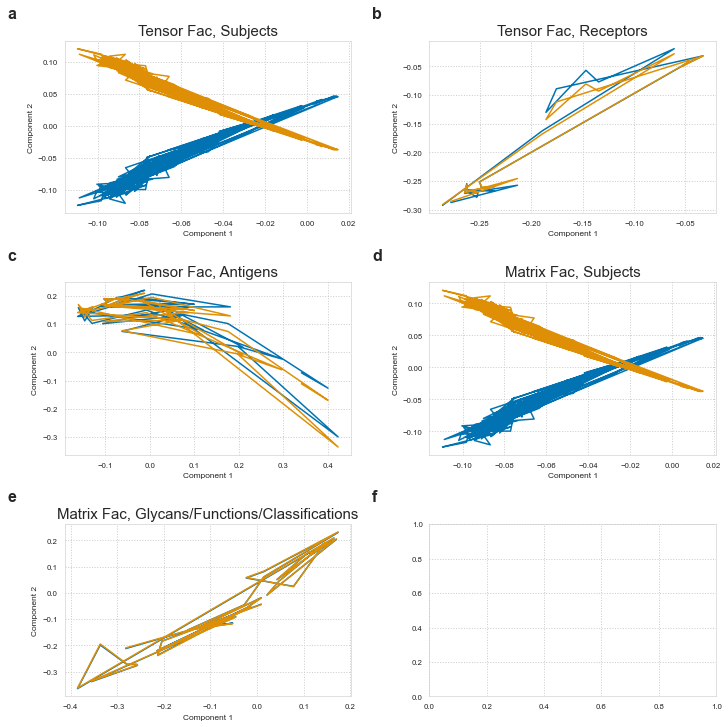

In [76]:
tensorFac, matrixFac, R2XX = perform_CMTF(cube, glyCube, 1)
tensorFac2, matrixFac2, R2XX2 = perform_CMTF(cube, glyCube, 2)
size = 5
ax, f = getSetup((10, 10), (3, 2))
ax[0].plot(tensorFac[1][0], tensorFac2[1][0])
ax[0].set_title("Tensor Fac, Subjects", fontsize = 15)
ax[1].plot(tensorFac[1][1], tensorFac2[1][1])
ax[1].set_title("Tensor Fac, Receptors", fontsize = 15)
ax[2].plot(tensorFac[1][2], tensorFac2[1][2])
ax[2].set_title("Tensor Fac, Antigens", fontsize = 15)
ax[3].plot(matrixFac[1][0], matrixFac2[1][0])
ax[3].set_title("Matrix Fac, Subjects", fontsize = 15)
ax[4].plot(matrixFac[1][1], matrixFac2[1][1])
ax[4].set_title("Matrix Fac, Glycans/Functions/Classifications", fontsize = 15)
for i in range(size):
    ax[i].set_ylabel("Component 2")
    ax[i].set_xlabel("Component 1")
subplotLabel(ax)

In [86]:
tensorFac[1][0, :]

TypeError: list indices must be integers or slices, not tuple